# Phase III beginning: ML Model (Proof of Conecpt)

### <font color='red'> DS3000 SEC04 (Spring 2025) </font>

### <font color='red'> Professor: Dr. Mohit Singhal </font>

### <font color='red'> Team Members: Tarun, Ryan, Saanika, Alex </font>


# Examining the relationship between Foreign Direct Investment and GDP Growth (%) for the linear regression

**x = Foreign Direct Investment**
**y = GDP Growth (%)**

In this project, we are aiming to analyze the potential relationship between Foreign Direct Investment (FDI) and GDP Growth (%) using linear regression. The purpose is to explore how FDI inflows influence economic growth, as measured by GDP growth rates obtained from the World Bank's API.

**Key Concepts:**
Foreign Direct Investment (FDI) refers to investments made from an entitty one country into business interests located in another foreign country/region. This could include building new businesses, acquiring existing businesses, or expanding business operations by means of offshoring.

GDP Growth (%) represents the percentage change in the gross domestic product of a country over a specified period, in this data set, the time frame is a year. It is a critical indicator of economic performance that is measured across the entire globe!

**Problem Statement:**
We hypothesize that FDI could play a crucial role in stimulating economic growth by bringing in capital, technology, and expertise. By examining the linear relationship between these two variables, we hope to understand if there is a correlation between the two variables for various regions around the world.

<!-- 
Matrix multiplciation to run the regression on these data points doing this for 5 of the regions
Do the things from the homework, calculating Ypreds, resids, MSE, and R2 for the five regions
Then plot the regressions for the five regions essentially replicating part 2 of the HW.
Include some commentary for us to explain the  -->

In [9]:
import requests
import pandas as pd

# merged_df = pd.DataFrame()
 
# Define indicators
gdp_indicator = "NY.GDP.MKTP.KD.ZG"  # GDP Growth (%)
unemployment_indicator = "SL.UEM.TOTL.ZS"  # Unemployment Rate (%)
inflation_indicator = "FP.CPI.TOTL.ZG"  # Inflation Rate (%)
fdi_indicator = "BX.KLT.DINV.WD.GD.ZS" # FDI Amount ($)

years = list(range(2000, 2023))

# Function that gets all data from World Bank API
def fetch_data(indicator):
    url = f"http://api.worldbank.org/v2/country/all/indicator/{indicator}?date={years[0]}:{years[-1]}&format=json&per_page=1000"
    response = requests.get(url)
    data = response.json()

    return pd.DataFrame([
        {"Country": entry["country"]["value"],
         "Code": entry["country"]["id"],
         "Year": entry["date"],
         "Value": entry["value"]}
        for entry in data[1]
    ]) if isinstance(data, list) and len(data) > 1 else pd.DataFrame()

# Get data for each indicator
gdp_df = fetch_data(gdp_indicator).rename(columns = {"Value": "GDP Growth (%)"})
unemployment_df = fetch_data(unemployment_indicator).rename(columns = {"Value": "Unemployment Rate (%)"})
inflation_df = fetch_data(inflation_indicator).rename(columns = {"Value": "Inflation Rate (%)"})
fdi_df = fetch_data(fdi_indicator).rename(columns = {"Value": "Foreign Direct Investment"})


 # Merge all the coloumns
merged_df = gdp_df.merge(unemployment_df, on=["Country","Code", "Year"], how="outer")
merged_df = merged_df.merge(inflation_df, on=["Country", "Code", "Year"], how="outer")
merged_df = merged_df.merge(fdi_df, on=["Country", "Code","Year"], how="outer")


# Save to CSV
# merged_df.to_csv("foundationsOfDataScienceProject.csv")

merged_df[: 70]

,Country,Code,Year,GDP Growth (%),Unemployment Rate (%),Inflation Rate (%),Foreign Direct Investment
0,Africa Eastern and Southern,ZH,2000,3.214946,7.788317,8.601485,1.533787
1,Africa Eastern and Southern,ZH,2001,3.505726,7.676955,5.840354,4.773985
2,Africa Eastern and Southern,ZH,2002,3.836078,7.632330,8.763754,2.471801
3,Africa Eastern and Southern,ZH,2003,2.956241,7.586883,7.449700,2.460783
4,Africa Eastern and Southern,ZH,2004,5.555397,7.395648,5.023421,1.840140
...,...,...,...,...,...,...,...
65,Arab World,1A,2019,1.583715,10.216098,1.091848,1.225902
66,Arab World,1A,2020,-4.711784,11.325613,1.612222,1.304955
67,Arab World,1A,2021,4.031106,10.889659,2.965810,2.346639
68,Arab World,1A,2022,5.721433,9.953571,5.087542,2.195336


### **1. The first thing we'll do to prepare for a linear regression machine leanring model is create seperate dataframes for each region:**

In [10]:
# Creating seperate dataframes for each of the regions to perform a linear regression ML model

countries = ["Africa Eastern and Southern", "Latin America & Caribbean", "Europe & Central Asia", "Middle East & North Africa", "East Asia & Pacific"]

africa_df = merged_df[merged_df['Country'] == countries[0]]
latin_america_df = merged_df[merged_df['Country'] == countries[1]]
europe_df = merged_df[merged_df['Country'] == countries[2]]
middle_east_df = merged_df[merged_df['Country'] == countries[3]]
east_asia_df = merged_df[merged_df['Country'] == countries[4]]

latin_america_df.head()

,Country,Code,Year,GDP Growth (%),Unemployment Rate (%),Inflation Rate (%),Foreign Direct Investment
529,Latin America & Caribbean,ZJ,2000,3.619345,9.461823,4.608230,3.594008
530,Latin America & Caribbean,ZJ,2001,0.454998,9.067123,4.055081,3.348054
531,Latin America & Caribbean,ZJ,2002,0.465824,9.406549,3.950117,2.715295
532,Latin America & Caribbean,ZJ,2003,2.460345,9.267108,3.733736,2.290706
533,Latin America & Caribbean,ZJ,2004,5.439116,8.751233,4.380323,2.958688


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

"""
Now let's create two functions:
1. The first will add a column of ones into the input data, which will allow the
model to estimate the y-intercept as well as the slope of the regression line.
    - This is a crucial preprocessing step for this type of model.
"""

# Functions for adding a bias column and calculating line of best fit
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """

    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
    else:
        raise ValueError("Input array must be either 1-d or 2-d")
    return Xnew

"""
The next function takes the data from x and y, adds the bias column using the above function, and 
calculates the slope and intercept of the line of best fit. It does so by using the 
Ordinary Least Squares method / Normal Equation.
"""

def line_of_best_fit(X, y):
    """
    Args:
        X (array): can be either 1-d or 2-d
        y (arrya): a 1-D 
    
    Returns:
        m - an array with the Slope of the Line of Best fit, and the intercept value for the line of best fit
    """

    Xnew = add_bias_column(X)
    b = np.matmul(np.linalg.inv(np.matmul(Xnew.T, Xnew)), np.matmul(Xnew.T, y))
    np.set_printoptions(suppress=True)
    return b

"""
Next, using the specified x and y for the specific region, the linreg_predict function will use the 
data, and the slope and intercept from the line_of_best_fit function to run the regression
"""

# Linear regression prediction and residuals calculation
def linreg_predict(Xnew, ynew, m):
    '''
    Args:
    Takes in Xnew (1-d or 2-d array with predictor features (not including bias term)
    Takes in ynew (a 1-d array which includes all corresponding response values to Xnew
    m, a 1-d array of length p + 1 which contains the coefficients from the `line_of_best_fit` function

    Returns:
    ypreds, resids, mse, and r2 in a dictionary 
    '''

    Xnew = add_bias_column(Xnew)
    ypreds = np.sum(Xnew * m, axis=1)
    resids = ynew - ypreds
    mse = np.sum((resids**2)) / len(resids)
    r2 = r2_score(ynew, ypreds)
    return {'ypreds': ypreds, 'resids': resids, 'mse': mse, 'r2': r2}

"""
Next using a cross validated sample of the data, the plot_residuals_analysis function will plot the 
various graphs that will help us determine if the model for the linear regression is correctly specified.
# 1. Residuals vs Fitted plot
# 2. Residual Plot vs Order
# 3. Normal Q-Q plot
# 4. Histogram of Residuals
"""

# Residual analysis functions
def plot_residuals_analysis(y_true, y_pred, residuals):
    """
    Args:
    y_true from the cross validation
    y_Pred from the cross validation
    residuals from Y_true - y_pred
    
    Returns:
    # 1. Residuals vs Fitted plot
    # 2. Residual Plot vs Order
    # 3. Normal Q-Q plot
    # 4. Histogram of Residuals
    """

    # 1. Residuals vs Fitted plot
    plt.figure(figsize = (10, 6))
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color = 'blue', linestyle = '--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted")
    plt.show()

    # 2. Residual Plot vs Order
    plt.figure(figsize = (10, 6))
    plt.scatter(range(len(residuals)), residuals)
    plt.axhline(0, color = 'blue', linestyle = '--')
    plt.xlabel("Order of Data")
    plt.ylabel("Residuals")
    plt.title("Residual Plot vs Order")
    plt.show()

    # 3. Normal Q-Q plot
    plt.figure(figsize = (10, 6))
    stats.probplot(residuals, dist = "norm", plot = plt)
    plt.title("Normal Q-Q Plot")
    plt.show()

    # 4. Histogram of Residuals
    plt.figure(figsize = (10, 6))
    sns.histplot(residuals, kde = True, bins = 15)
    plt.title("Histogram of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

"""
Finally, the evaluate Model function will be used to tie all of the other functions above together.

The model will plot the data vs the line of best fit that is fitted to the historical data.

The function will also perform cross validation on the data, splitting it into training and 
testing data. This will be used to validate the model, and check that the assumptions
of a linear regression are not being violated.

Additionally, the function will call plot_residuals_analysis on the cross validated 
sample of the data.
"""

# Function to train and evaluate the model
def evaluate_model(X, y, region_name):

    # Testing the regression before cross validation
    X = X
    y = y
    all_data_m = line_of_best_fit(X, y)
    all_data_result = linreg_predict(X, y, all_data_m)

    print('Plotting the historical Data with the Line of best fit')

    # Plot the results from the full data set
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, label='Actual Data', alpha=0.7)
    plt.plot(X, all_data_result['ypreds'], color='red', label='Best Fit Line')
    plt.xlabel("Foreign Direct Investment (%)")
    plt.ylabel("GDP Growth (%)")
    plt.title(f"GDP vs FDI for {region_name}")
    plt.legend()
    plt.show()

    # Cross validating the data in the regression analysis
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    m = line_of_best_fit(X_train, y_train)
    result = linreg_predict(X_test, y_test, m)

    print(f"Model for {region_name}:")
    print(f"Mean Squared Error: {round(result['mse'], 3)}")
    print(f"R² Score: {round(result['r2'], 3)}")

    # Plot the results from the cross validated sample
    plt.figure(figsize = (8, 5))
    plt.scatter(X_test, y_test, label = 'Actual Data', alpha = 0.7)
    plt.plot(X_test, result['ypreds'], color='red', label = 'Best Fit Line')
    plt.xlabel("Foreign Direct Investment (%)")
    plt.ylabel("GDP Growth (%)")
    plt.title(f"GDP vs FDI for {region_name}")
    plt.legend()
    plt.show()

    # Perform residuals analysis
    plot_residuals_analysis(y_test, result['ypreds'], result['resids'])



Evaluating model for Africa Eastern and Southern...

Plotting the historical Data with the Line of best fit


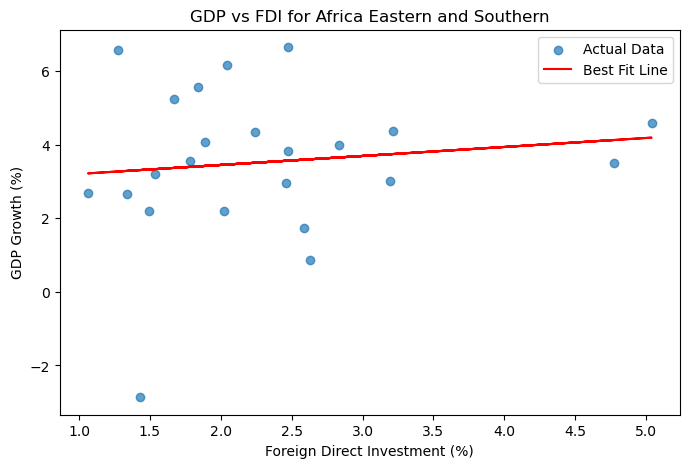

Model for Africa Eastern and Southern:
Mean Squared Error: 3.03
R² Score: -1.648


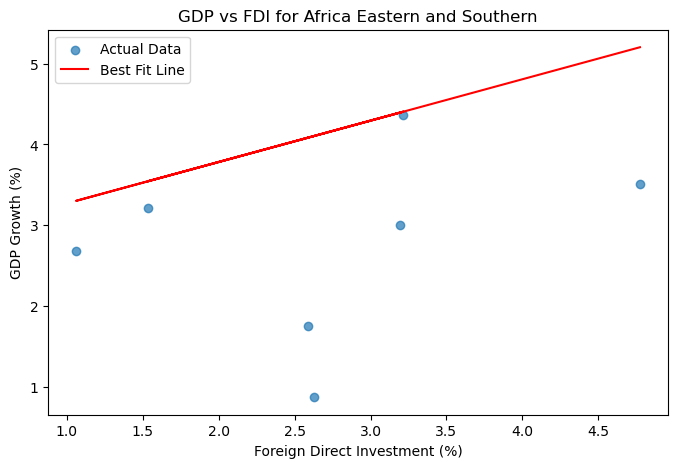

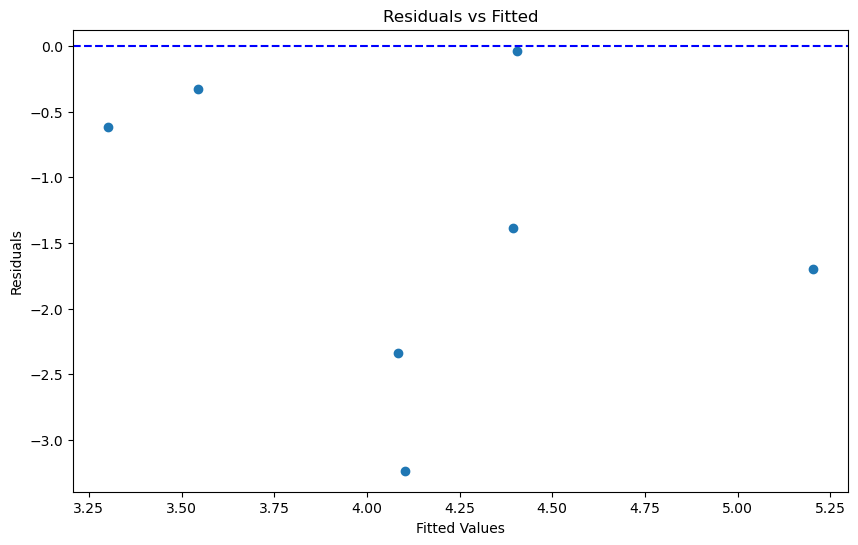

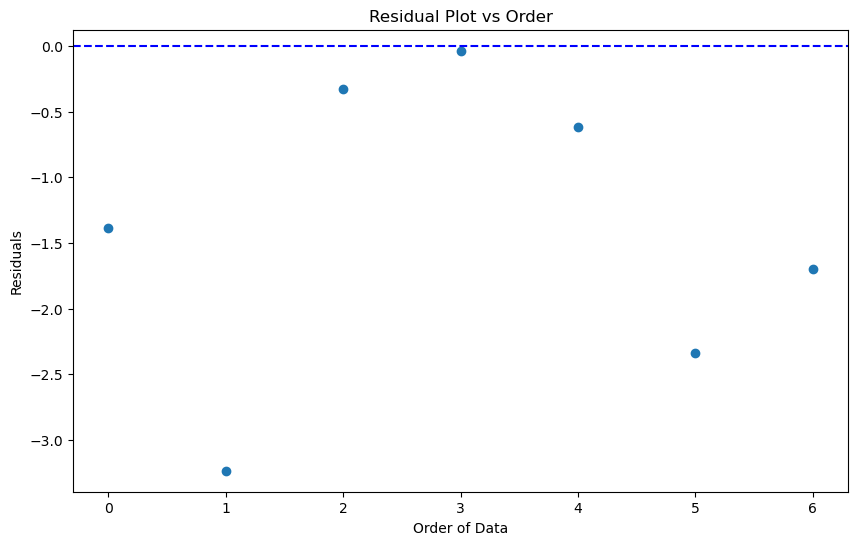

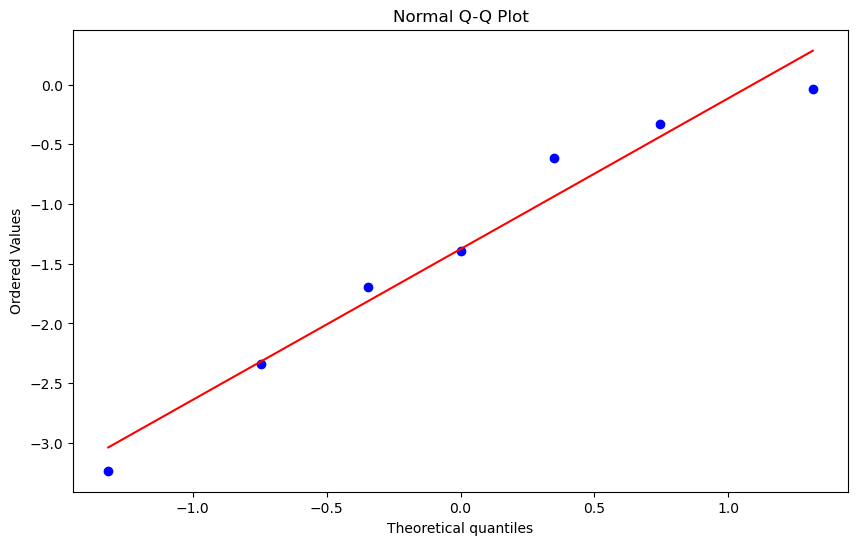

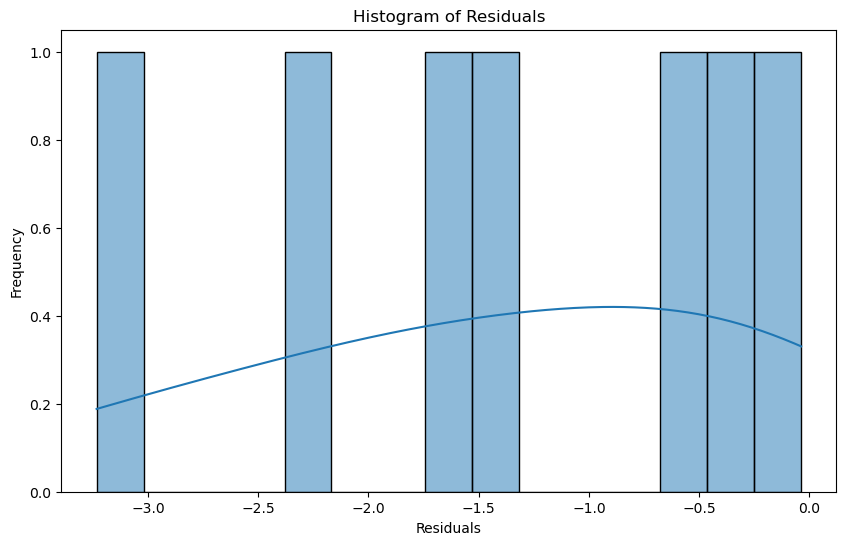


Evaluating model for Latin America & Caribbean...

Plotting the historical Data with the Line of best fit


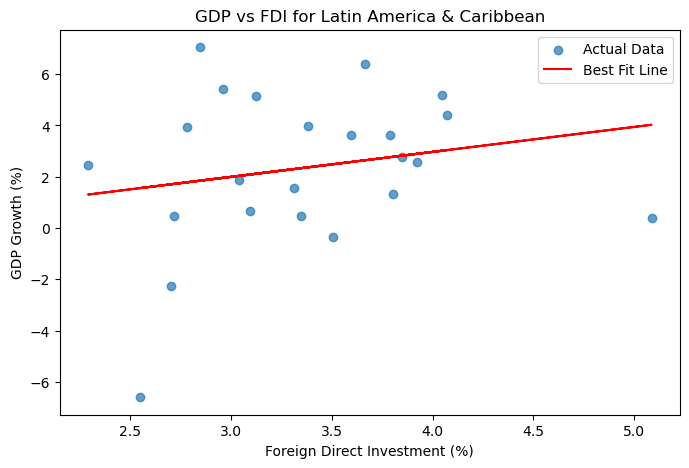

Model for Latin America & Caribbean:
Mean Squared Error: 8.253
R² Score: -1.145


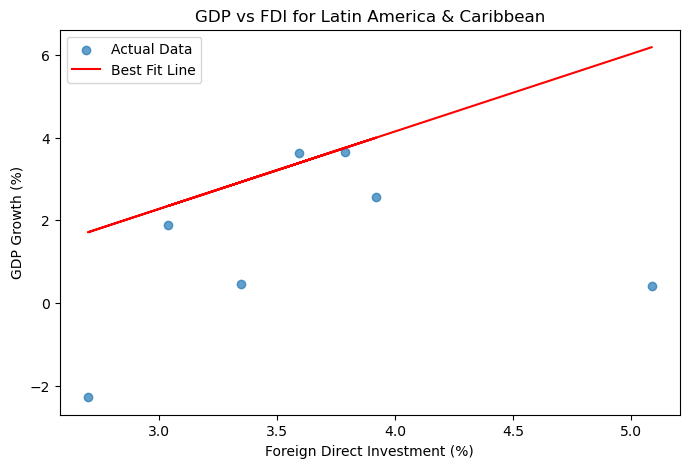

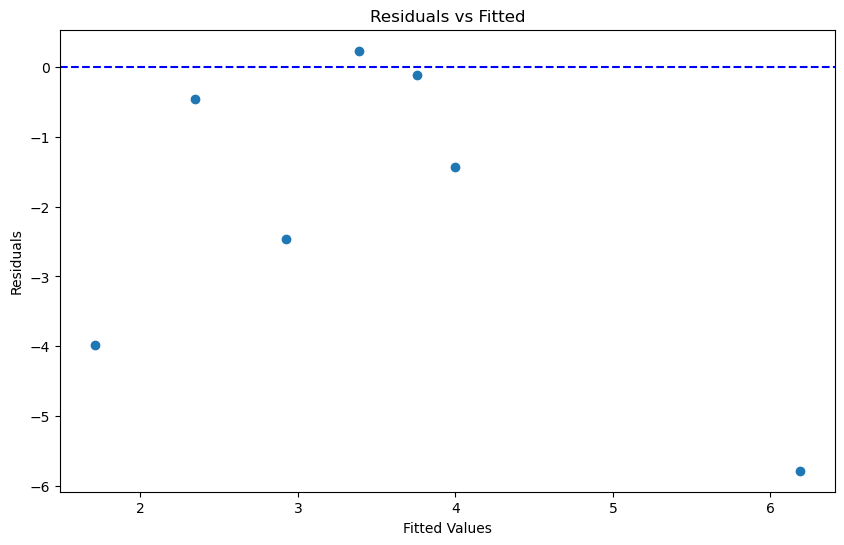

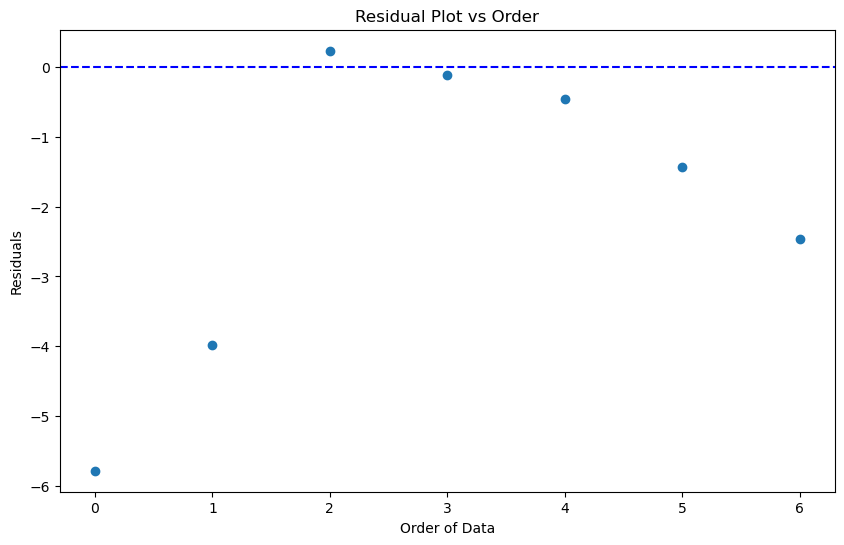

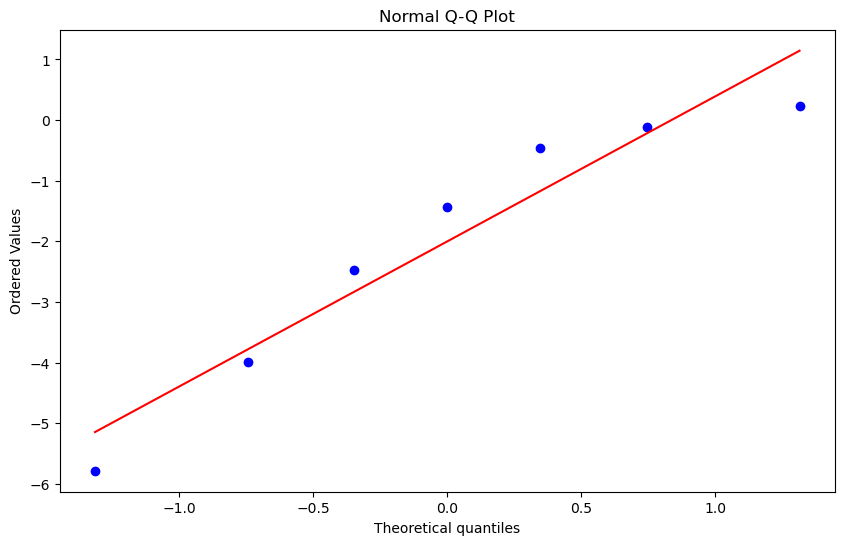

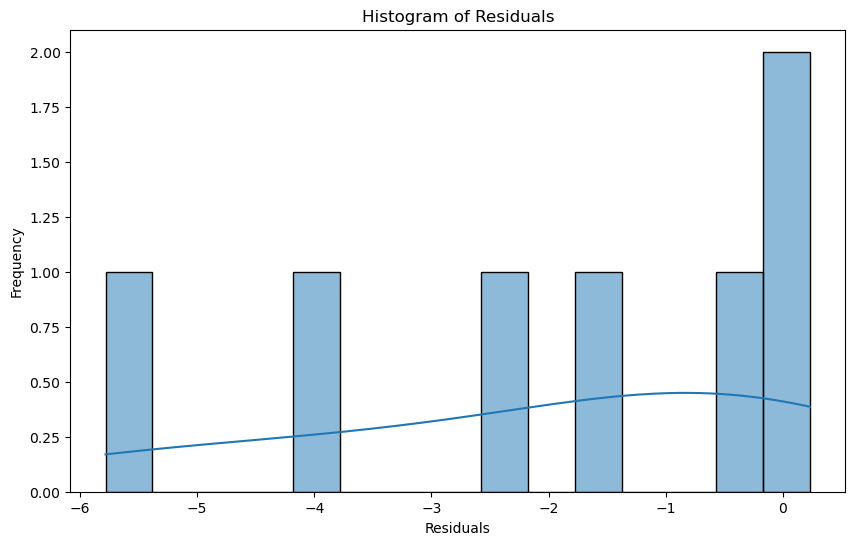


Evaluating model for Europe & Central Asia...

Plotting the historical Data with the Line of best fit


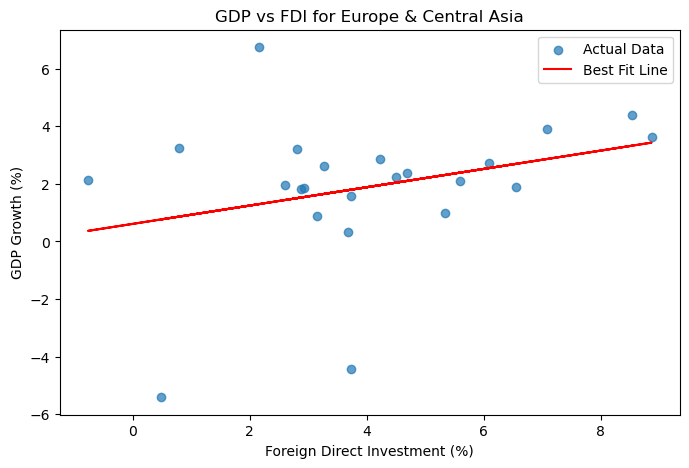

Model for Europe & Central Asia:
Mean Squared Error: 7.485
R² Score: -0.106


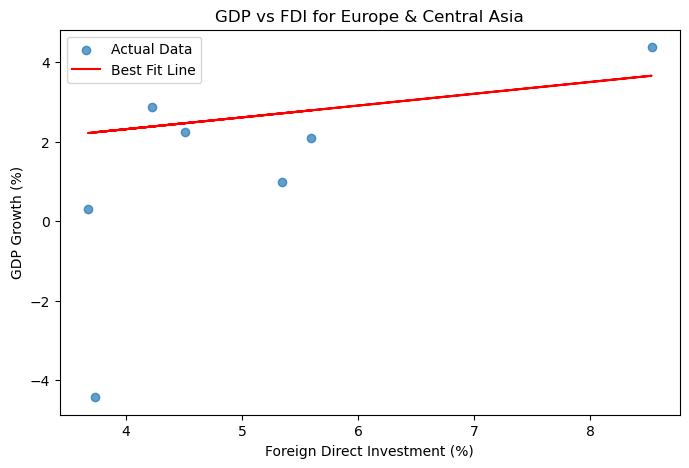

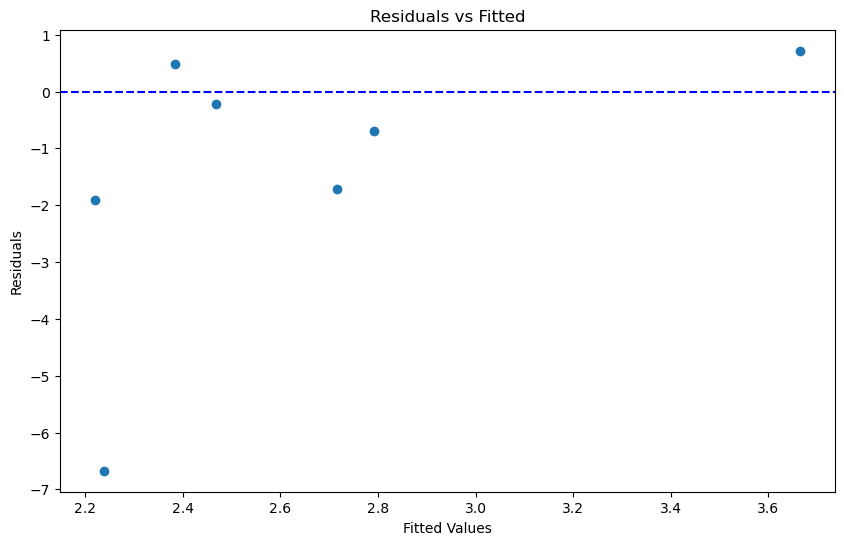

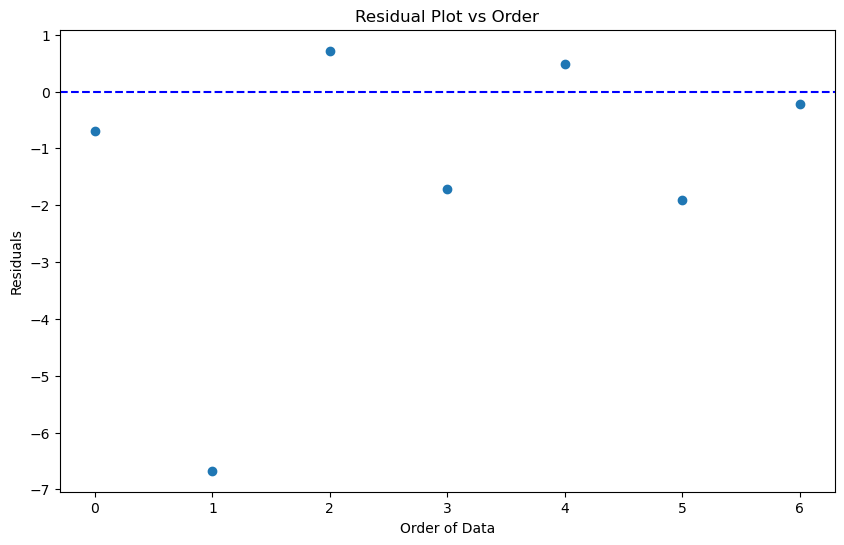

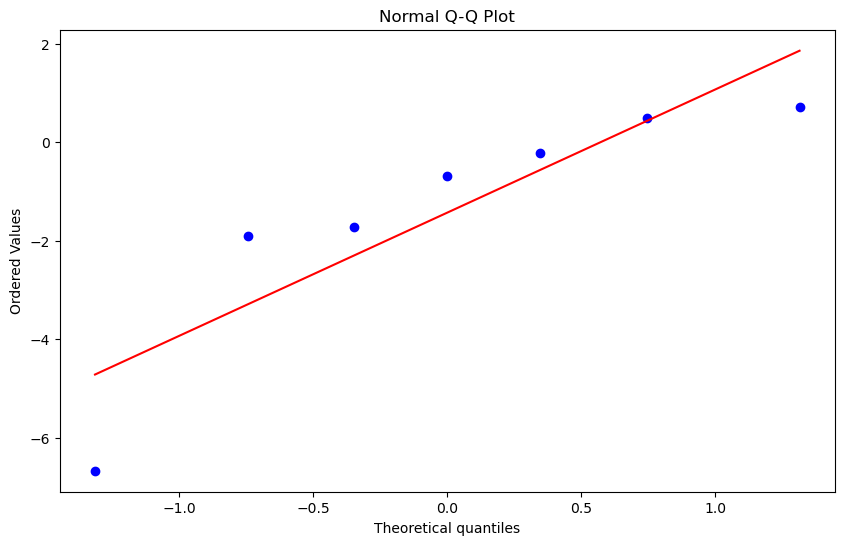

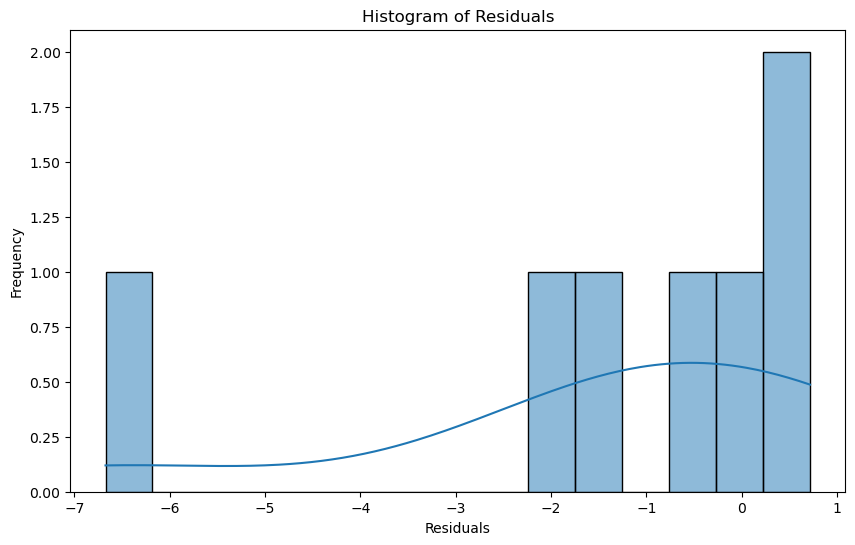


Evaluating model for Middle East & North Africa...

Plotting the historical Data with the Line of best fit


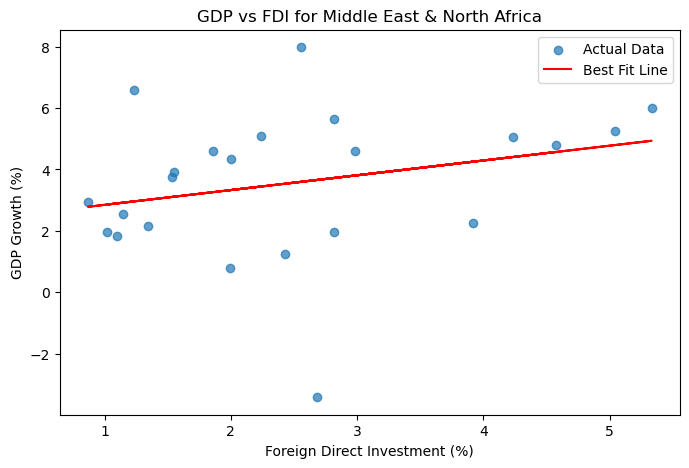

Model for Middle East & North Africa:
Mean Squared Error: 3.62
R² Score: -0.087


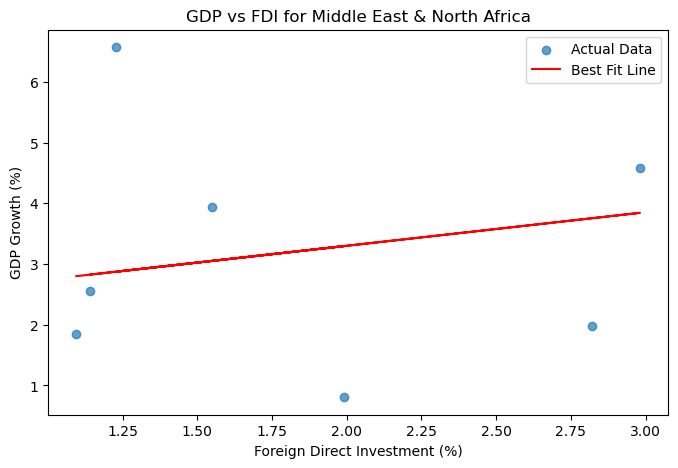

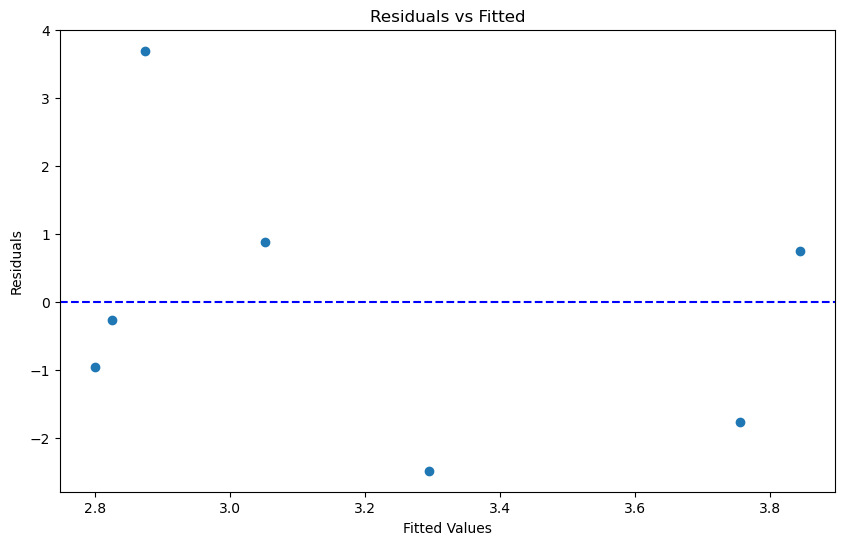

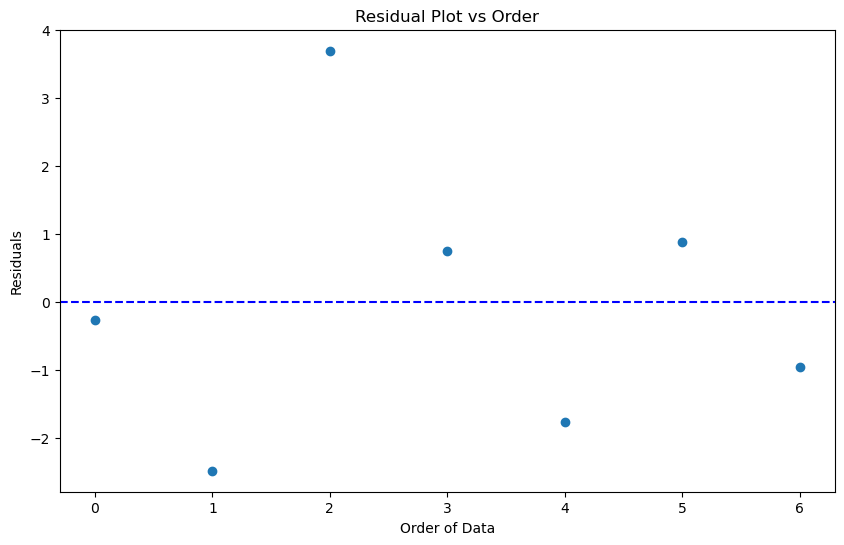

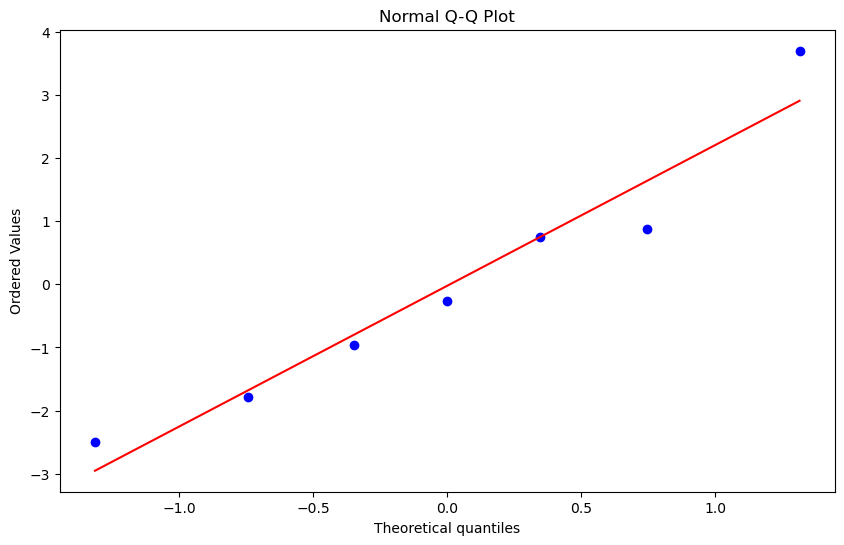

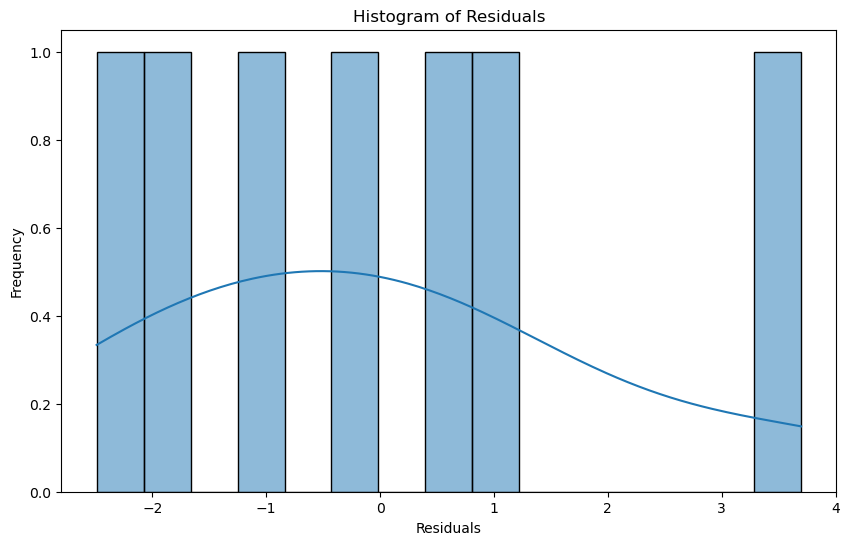


Evaluating model for East Asia & Pacific...

Plotting the historical Data with the Line of best fit


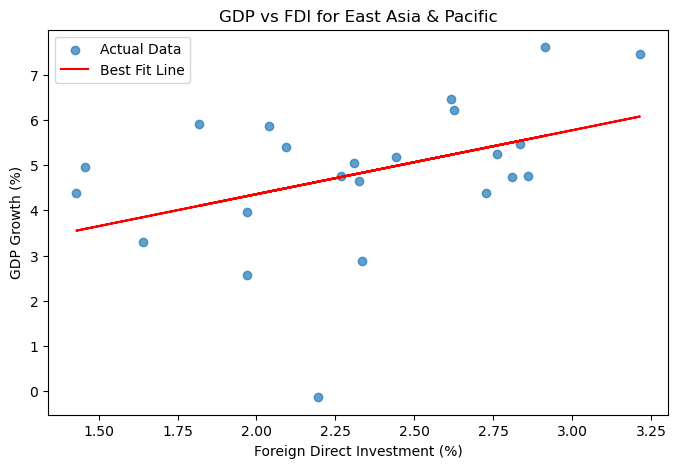

Model for East Asia & Pacific:
Mean Squared Error: 1.001
R² Score: -0.042


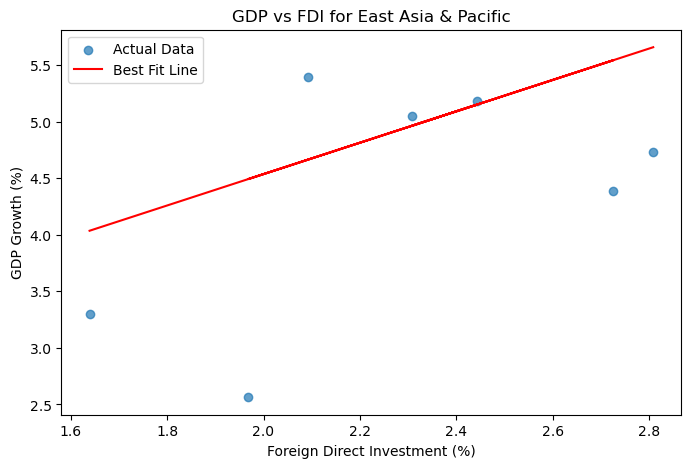

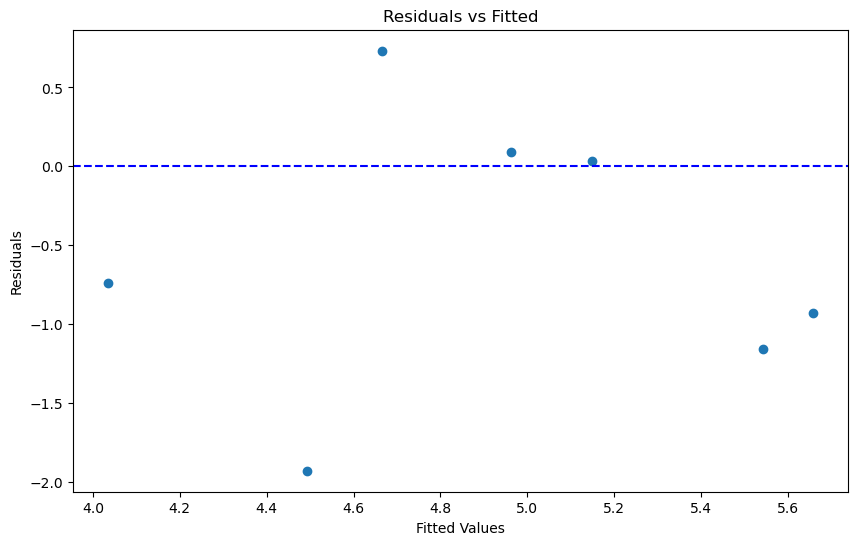

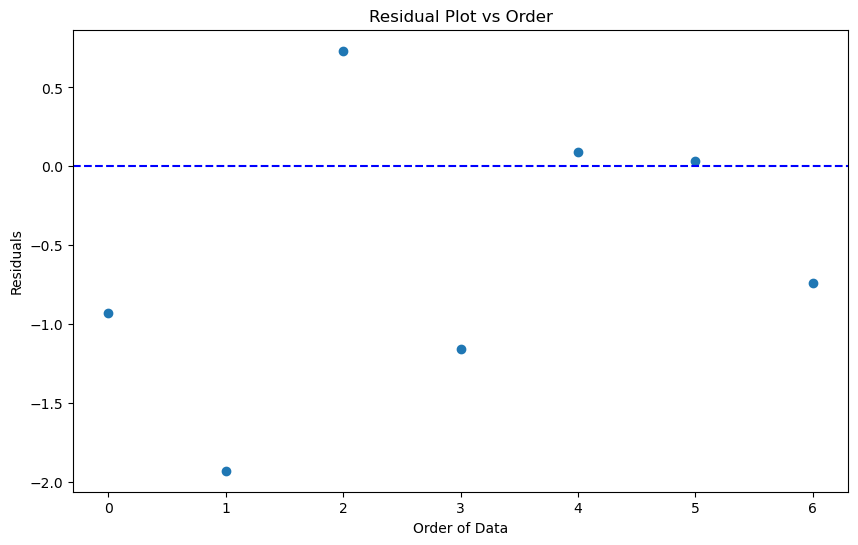

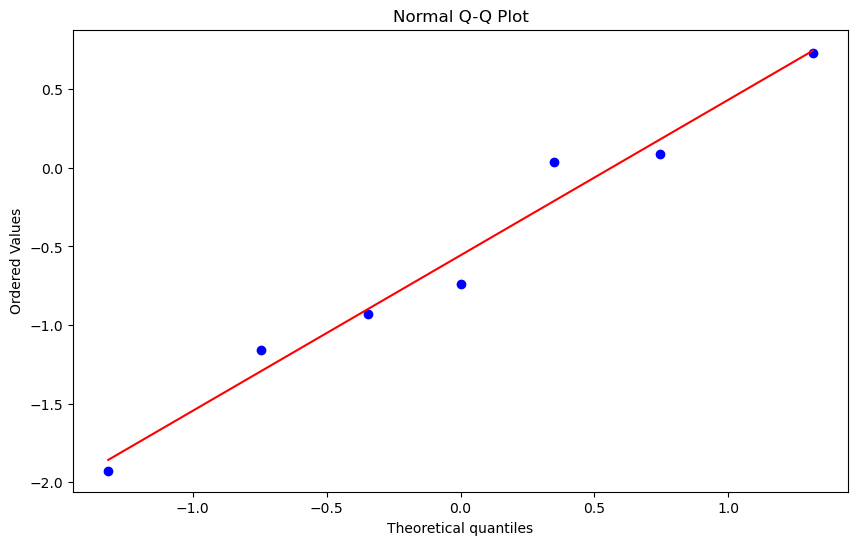

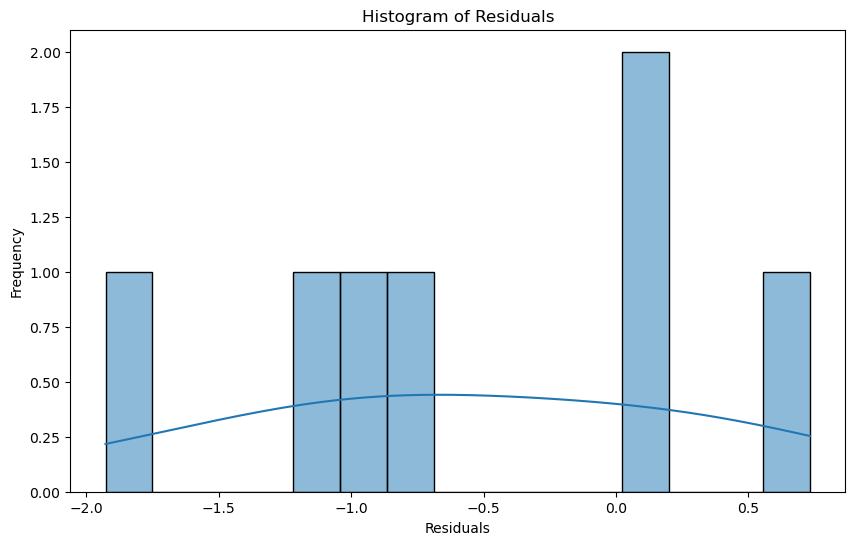

In [12]:
# List of region names and corresponding dataframes with data for x and y values for regresison
regions = [
    ("Africa Eastern and Southern", africa_df['Foreign Direct Investment'], africa_df['GDP Growth (%)']),
    ("Latin America & Caribbean", latin_america_df['Foreign Direct Investment'], latin_america_df['GDP Growth (%)']),
    ("Europe & Central Asia", europe_df['Foreign Direct Investment'], europe_df['GDP Growth (%)']),
    ("Middle East & North Africa", middle_east_df['Foreign Direct Investment'], middle_east_df['GDP Growth (%)']),
    ("East Asia & Pacific", east_asia_df['Foreign Direct Investment'], east_asia_df['GDP Growth (%)'])
]

# Loop through each region, evaluate the model, and show results in the plots from the plot residuals function embeded within the evaluate model function
for region_name, X, y in regions:
    print(f"\nEvaluating model for {region_name}...\n")
    evaluate_model(X, y, region_name)


In [13]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def add_bias_column(X):
    """Adds a bias column of 1s to the input array.
    
    Args:
        X (array): Can be either 1D or 2D.
    
    Returns:
        Xnew (array): The same array, but with a bias column added.
    """
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
    else:
        raise ValueError("Input array must be either 1D or 2D")
    return Xnew

def line_of_best_fit(X, y):
    """Computes the coefficients for the best-fit polynomial regression model.
    
    Args:
        X (array): Independent variable (without bias term).
        y (array): Dependent variable.
    
    Returns:
        m (array): Coefficients of the polynomial regression model, including intercept.
    """
    X_new = add_bias_column(X)  # Add bias column
    XtX_inv = np.linalg.inv(np.matmul(X_new.T, X_new))
    m = np.matmul(XtX_inv, np.matmul(X_new.T, y))
    return m

def linreg_predict(Xnew, ynew, m):
    """Predicts values and evaluates model performance.
    
    Args:
        Xnew (array): Independent variable (without bias term).
        ynew (array): Actual dependent variable values.
        m (array): Model coefficients.
    
    Returns:
        output_dict (dict): Dictionary with predictions, residuals, MSE, and R².
    """
    output_dict = {}
    Xnew_bias_added = add_bias_column(Xnew)
    ypreds = np.matmul(Xnew_bias_added, m)  # Predictions
    res = ynew - ypreds  # Residuals
    mse = (res**2).mean()  # Mean Squared Error
    r2 = r2_score(ynew, ypreds)  # R2 Score

    output_dict['mse'] = mse
    output_dict['r2'] = r2
    return output_dict

def polynomial_regression_for_region(region_name, X, y, degree=4):
    """Applies polynomial regression to a specific region's dataset.
    
    Args:
        region_name (str): Name of the region.
        X (array): Independent variable (FDI).
        y (array): Dependent variable (GDP Growth).
        degree (int): Degree of the polynomial model.
    
    Returns:
        None
    """
    X = np.array(X).reshape(-1, 1)
    y = np.array(y)

    # Transform features into polynomial form
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(X)[:, 1:]  # Remove bias term since we'll add it separately

    # Corss Validation using Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=3)

    # Compute best-fit polynomial model
    m = line_of_best_fit(X_train, y_train)
    model_results = linreg_predict(X_test, y_test, m)

    print(f"Polynomial Regression (d= {degree}) for {region_name}:")
    print(f"MSE: {round(model_results['mse'], 3)}")
    print(f"R²: {round(model_results['r2'], 3)}\n")

# Apply polynomial regression for each region
regions = [
    ("Africa Eastern and Southern", africa_df['Foreign Direct Investment'], africa_df['GDP Growth (%)']),
    ("Latin America & Caribbean", latin_america_df['Foreign Direct Investment'], latin_america_df['GDP Growth (%)']),
    ("Europe & Central Asia", europe_df['Foreign Direct Investment'], europe_df['GDP Growth (%)']),
    ("Middle East & North Africa", middle_east_df['Foreign Direct Investment'], middle_east_df['GDP Growth (%)']),
    ("East Asia & Pacific", east_asia_df['Foreign Direct Investment'], east_asia_df['GDP Growth (%)'])
]

for region_name, X, y in regions:
    polynomial_regression_for_region(region_name, X, y, degree = 4)


Polynomial Regression (d= 4) for Africa Eastern and Southern:
MSE: 396759.226
R²: -464930.088

Polynomial Regression (d= 4) for Latin America & Caribbean:
MSE: 4559.033
R²: -870.52

Polynomial Regression (d= 4) for Europe & Central Asia:
MSE: 6.529
R²: -0.919

Polynomial Regression (d= 4) for Middle East & North Africa:
MSE: 0.718
R²: 0.39

Polynomial Regression (d= 4) for East Asia & Pacific:
MSE: 3.157
R²: -3.911



# Preliminary Discussion + Ethics of the project

We tested whether Foreign Direct Investment (FDI) could be used to predict GDP Growth (%) using linear regression models built for five different regions. We used historical data provided from the World Bank's API, and created filtered datasets for the following regions:

- Africa Eastern and Southern
- Latin America & Caribbean
- Europe & Central Asia
- Middle East & North Africa
- East Asia & Pacific.

The models were designed to test whether FDI alone could be a useful predictor of future GDP Growth, and we used basic error metrics like R² and Mean Squared Error (MSE) to evaluate model performance. Since the model only had one predictor, this phase was meant to be a first step, not to build a perfect fit, but instead to understand whether any clear linear relationship existed between these two variables.

The model results showed that FDI on its own is most likely not a reliable predictor future of GDP Growth. In every region, R² was close to zero or negative, meaning the model didn’t explain much, if any, of the variance in GDP growth. In fact, negative R² values across all five regions indicate that the predictions were worse than simply using the regional mean GDP growth as a baseline. For example, the R² in Africa Eastern and Southern was -1.648, and in Latin America & Caribbean it was -1.145. Even the best-performing model, in East Asia & Pacific, had an R² of -0.042. MSE scores also confirmed that error was relatively high and inconsistent, depending on the region. These values collectively suggest that GDP growth is driven by more economic features than just FDI, and any signal that might exist is likely non-linear, inconsistent across time, or both.

We ran diagnostic plots to test how well the models met the assumptions behind linear regression. Residuals vs. fitted value plots showed clear signs of structure — in many cases, the residuals were clustered or fanned out, indicating the errors weren’t evenly distributed and the model may have missed key nonlinear trends. The residuals vs. order plots sometimes showed subtle time-based patterns, which suggests there may be unaccounted-for temporal effects. In some regions, the residuals seemed to trend upward or downward depending on the order of the data points. Histograms of residuals were not symmetric in several cases due to the low sample size of data being used (leading to a low number of residuals from the cross validated sample), and the Q-Q plots frequently deviated from the line, confirming that the residuals weren’t normally distributed. **Altogether, these plots showed that multiple assumptions were violated — including linearity, independence, and normality, which helps explain the poor fit.**

These findings reinforce that GDP growth is not something that can be modeled accurately using FDI alone, especially across entire regions that group together very different countries. The fact that residual plots often showed clear structure means that there may be other influencing variables that weren’t included (potentially additional data points are available on the world Bank's API.). A model assuming a consistent, linear relationship between FDI and GDP is likely too simple to accurately describe the real world due to high levels of complexity that FDI cannot address on its own. These early results are useful because they point us toward the limitations of relying on a single metric and emphasize the need to consider additional economic, political, and social factors.

# Additional things we could do to improve our Model:

### Our Data Sample Size is somewhat small, but there are limitations to increasing the sample size
Using the current data we have at the moment, we are looking at economic data from the time frame 2000 - 2023. This is only providing us with a sample size of ~23 data points for each regression. While we would like to add some additional years to the data, we believe this may be unwise due to the difference between the time periods that could impact the interpretability of the model due to the difference in the times (due to potential structural differences (economic crisis, regime changes, recessions and expansions etc...))

### Increasing the size of the cross validation sample
Due to the small size of the sample data, we could increase the % of the training data for the cross validation model to attempt to rectify the problem resulting from the small sample size, however, it could lead to our model becoming overfit.

# Discussion of Ethical Implication:

There are also important ethical issues to acknowledge when working with this type of model. 
1. There's the risk of misinterpretation from the model we have created — a model with a clearly poor fit can still look convincing if presented out of context. Readers might assume there's a direct, causal link between FDI and GDP Growth, when in reality the model shows otherwise. 

2. Data reported to the World Bank can vary in accuracy and completeness between countries and across the years in the historical period. **These potential inconsistrenecies could influence results in subtle ways**. 

3. Treating entire regions (**e.g. Africa East and Southern, or Latin America and the Carribean**) as homogenous units can hide important country-specific dynamics, especially in regions with a wide range of economies and political systems. These kinds of generalizations can lead to conclusions that don’t actually reflect what’s happening on the ground in individual countries. Lastly, using data like this for predictive modeling requires careful framing — the goal should be to explore patterns and test assumptions, not to draw policy conclusions from an oversimplified model.

# Moving Forward - Future ML Model Ideas:

An additional ML Model we would like to work on in the future is a classification model. While we have not fully developed what the classification model will be used to classify, some potential ideas include:

1. Predicting if a country is a 'developing country' or a 'developed country' based on their rate of GDP Growth. Developing regions and countries typically exhibit higher levels of growth, so there is potential that this feature of economic growth could be used to determine the economic growth status of a region

2. Predicting if a country is a 'developing country' or a 'developed country' based on their rate of Literacy (**a variable that is available on the world bank's API but not yet called into our data set.**). Developing regions and countries typically exhibit higher rates of literacy amoung their populations, so there is potential that this feature of lioteracy rates could be used to determine the economic status of a region.



In [14]:
# Drop rows with missing values
merged_df_cleaned = merged_df.dropna(subset=['Foreign Direct Investment', 'GDP Growth (%)', 'Country'])

# Prepare the data
X_fdi = np.array(merged_df_cleaned['Foreign Direct Investment']).reshape(-1, 1)
y = merged_df_cleaned['GDP Growth (%)']

# Convert Country to numerical codes
X_country = merged_df_cleaned['Country'].astype('category').cat.codes.values.reshape(-1, 1)

# Polynomial transformation (degree = 4)
poly = PolynomialFeatures(4)
X_fdi_poly_bias = poly.fit_transform(X_fdi)
X_fdi_poly = X_fdi_poly_bias[:, 1:]  

# Add interaction terms between polynomial features and country dummy variable
X_poly_interaction = np.concatenate([
    X_fdi_poly,                   # Polynomial features
    X_fdi_poly * X_country,       # Interaction terms
    (1 - X_country) * X_fdi_poly  # Alternative interaction terms
], axis = 1)

# Cross Validate the Model with Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly_interaction, y, test_size=0.3, random_state=3)

# Find the best-fit model from the model using the cross validated Data sample
m = line_of_best_fit(X_train, y_train)
model = linreg_predict(X_test, y_test, m)

print('MSE for polynomial regression with interactions =', model['mse'].round(3))
print('R² for polynomial regression with interactions =', round(model['r2'], 4))


MSE for polynomial regression with interactions = 10.034
R² for polynomial regression with interactions = -0.0947
